# Mouse Brain Visualization

This notebook provides simple visualization tools for mouse brain .nii.gz files using nibabel and scikit-image libraries.
It includes functionality to:
- Load and visualize .nii.gz files
- Display annotations in color
- Export annotated images as PNG files


In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, segmentation, measure
from pathlib import Path
import os
from collections import Counter

In [2]:
# Define file paths - update these to match your actual file locations
data_dir = Path('./data')

# Available files in the directory
files = {
    'template_10': data_dir / 'average_template_10.nii.gz',
    'template_25': data_dir / 'average_template_25.nii.gz',
    'annotation_10': data_dir / 'annotation_10.nii.gz',
    'annotation_25': data_dir / 'annotation_25.nii.gz',
    'annotation_boundary_10': data_dir / 'annotation_boundary_10.nii.gz',
    'annotation_boundary_25': data_dir / 'annotation_boundary_25.nii.gz'
}

# Check which files exist
available_files = {k: v for k, v in files.items() if v.exists()}
print("Available files:")
for name, path in available_files.items():
    print(f"  {name}: {path}")


Available files:
  template_10: data/average_template_10.nii.gz
  template_25: data/average_template_25.nii.gz
  annotation_10: data/annotation_10.nii.gz
  annotation_25: data/annotation_25.nii.gz
  annotation_boundary_10: data/annotation_boundary_10.nii.gz
  annotation_boundary_25: data/annotation_boundary_25.nii.gz


In [3]:
def load_nifti_file(filepath):
    """
    Load a NIfTI file and return the image object and data array.
    
    Parameters:
    filepath (str or Path): Path to the .nii.gz file
    
    Returns:
    tuple: (nibabel image object, numpy array)
    """
    try:
        img = nib.load(filepath)
        data = img.get_fdata()
        print(f"Loaded {filepath}")
        print(f"  Shape: {data.shape}")
        print(f"  Data type: {data.dtype}")
        print(f"  Value range: {data.min():.2f} to {data.max():.2f}")
        return img, data
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None, None


In [4]:
def visualize_slice(data, slice_idx, axis=2, title="Brain Slice", cmap='gray', figsize=(8, 6)):
    """
    Visualize a single slice from 3D brain data.
    
    Parameters:
    data (numpy.ndarray): 3D brain data
    slice_idx (int): Index of the slice to display
    axis (int): Axis along which to slice (0=sagittal, 1=coronal, 2=axial)
    title (str): Title for the plot
    cmap (str): Colormap for visualization
    figsize (tuple): Figure size
    
    Returns:
    matplotlib figure and axis objects
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Extract slice based on axis
    if axis == 0:  # sagittal
        slice_data = data[slice_idx, :, :]
        axis_name = "Sagittal"
    elif axis == 1:  # coronal
        slice_data = data[:, slice_idx, :]
        axis_name = "Coronal"
    else:  # axial
        slice_data = data[:, :, slice_idx]
        axis_name = "Axial"
    
    # Transpose for proper orientation
    slice_data = np.transpose(slice_data)
    
    im = ax.imshow(slice_data, cmap=cmap, origin='lower')
    ax.set_title(f"{title} - {axis_name} Slice {slice_idx}")
    ax.axis('off')
    
    # Add colorbar for non-gray images
    if cmap != 'gray' and cmap != 'Greys_r':
        plt.colorbar(im, ax=ax, shrink=0.8)
    
    plt.tight_layout()
    return fig, ax


In [5]:
def visualize_overlay(template_data, annotation_data, slice_idx, axis=2, 
                     alpha=0.6, template_cmap='gray', annotation_cmap='jet', 
                     figsize=(10, 8), title="Brain with Annotations"):
    """
    Visualize template with annotation overlay.
    
    Parameters:
    template_data (numpy.ndarray): 3D template data
    annotation_data (numpy.ndarray): 3D annotation data
    slice_idx (int): Index of the slice to display
    axis (int): Axis along which to slice
    alpha (float): Transparency of annotation overlay
    template_cmap (str): Colormap for template
    annotation_cmap (str): Colormap for annotations
    figsize (tuple): Figure size
    title (str): Title for the plot
    
    Returns:
    matplotlib figure and axis objects
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Extract slices
    if axis == 0:  # sagittal
        template_slice = template_data[slice_idx, :, :]
        annotation_slice = annotation_data[slice_idx, :, :]
        axis_name = "Sagittal"
    elif axis == 1:  # coronal
        template_slice = template_data[:, slice_idx, :]
        annotation_slice = annotation_data[:, slice_idx, :]
        axis_name = "Coronal"
    else:  # axial
        template_slice = template_data[:, :, slice_idx]
        annotation_slice = annotation_data[:, :, slice_idx]
        axis_name = "Axial"
    
    # Transpose for proper orientation
    template_slice = np.transpose(template_slice)
    annotation_slice = np.transpose(annotation_slice)
    
    # Display template as background
    ax.imshow(template_slice, cmap=template_cmap, origin='lower')
    
    # Create mask for non-zero annotations
    annotation_mask = annotation_slice > 0
    
    # Overlay annotations where they exist
    if np.any(annotation_mask):
        masked_annotations = np.ma.masked_where(~annotation_mask, annotation_slice)
        im = ax.imshow(masked_annotations, cmap=annotation_cmap, alpha=alpha, origin='lower')
        plt.colorbar(im, ax=ax, shrink=0.8, label='Annotation ID')
    
    ax.set_title(f"{title} - {axis_name} Slice {slice_idx}")
    ax.axis('off')
    plt.tight_layout()
    
    return fig, ax


In [6]:
def save_figure_as_png(fig, filename, dpi=300, bbox_inches='tight'):
    """
    Save a matplotlib figure as PNG file.
    
    Parameters:
    fig: matplotlib figure object
    filename (str): Output filename (with or without .png extension)
    dpi (int): Resolution for output image
    bbox_inches (str): Bounding box setting
    """
    if not filename.endswith('.png'):
        filename += '.png'
    
    fig.savefig(filename, dpi=dpi, bbox_inches=bbox_inches, 
                facecolor='white', edgecolor='none')
    print(f"Figure saved as: {filename}")


In [7]:
# Load template and annotation data
# Start with 25μm resolution for faster processing
if 'template_25' in available_files and 'annotation_25' in available_files:
    template_img, template_data = load_nifti_file(available_files['template_25'])
    annotation_img, annotation_data = load_nifti_file(available_files['annotation_25'])
    resolution = "25μm"
elif 'template_10' in available_files and 'annotation_10' in available_files:
    template_img, template_data = load_nifti_file(available_files['template_10'])
    annotation_img, annotation_data = load_nifti_file(available_files['annotation_10'])
    resolution = "10μm"
else:
    print("No matching template and annotation files found!")
    template_data, annotation_data = None, None


Loaded data/average_template_25.nii.gz
  Shape: (528, 320, 456)
  Data type: float64
  Value range: 0.00 to 516.00
Loaded data/annotation_25.nii.gz
  Shape: (528, 320, 456)
  Data type: float64
  Value range: 0.00 to 1327.00


Data shape: (528, 320, 456)
Middle slice indices - Sagittal: 264, Coronal: 160, Axial: 228


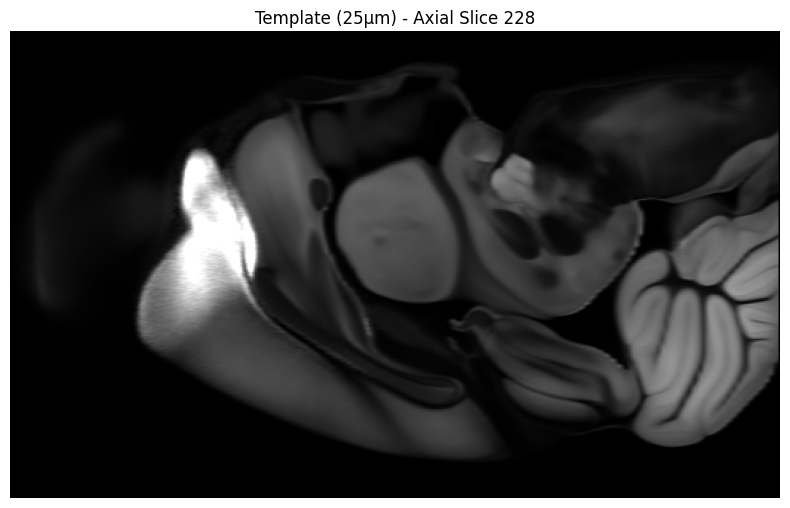

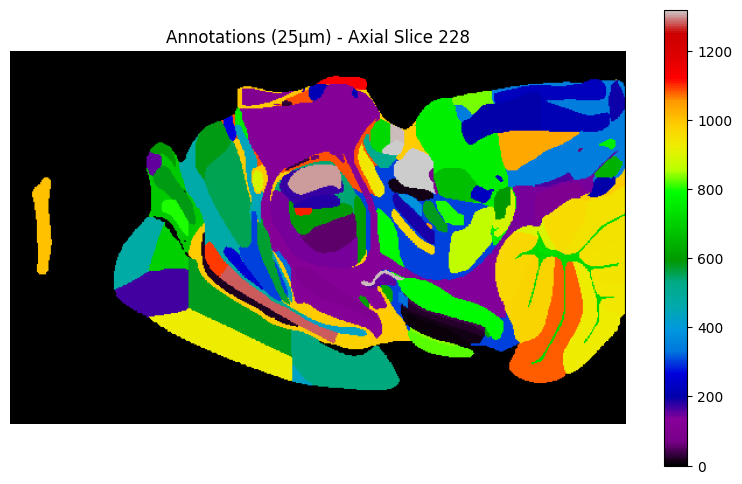

In [8]:
# Visualize middle slices if data is loaded
if template_data is not None and annotation_data is not None:
    # Calculate middle slice indices
    mid_sagittal = template_data.shape[0] // 2
    mid_coronal = template_data.shape[1] // 2
    mid_axial = template_data.shape[2] // 2
    
    print(f"Data shape: {template_data.shape}")
    print(f"Middle slice indices - Sagittal: {mid_sagittal}, Coronal: {mid_coronal}, Axial: {mid_axial}")
    
    # Visualize template alone (axial slice)
    fig1, ax1 = visualize_slice(template_data, mid_axial, axis=2, 
                               title=f"Template ({resolution})", cmap='gray')
    plt.show()
    
    # Visualize annotations alone (axial slice)
    fig2, ax2 = visualize_slice(annotation_data, mid_axial, axis=2, 
                               title=f"Annotations ({resolution})", cmap='nipy_spectral')
    plt.show()


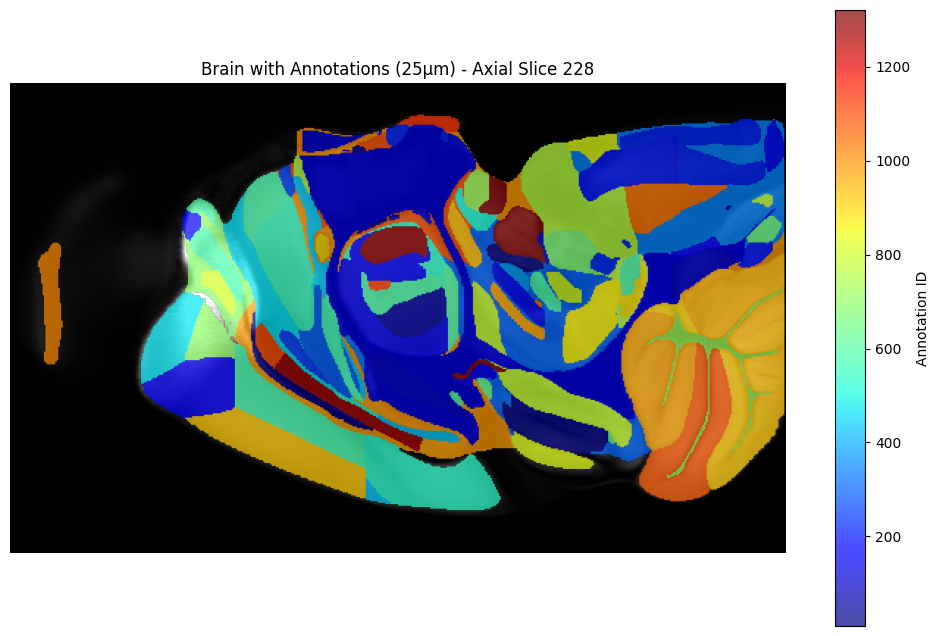

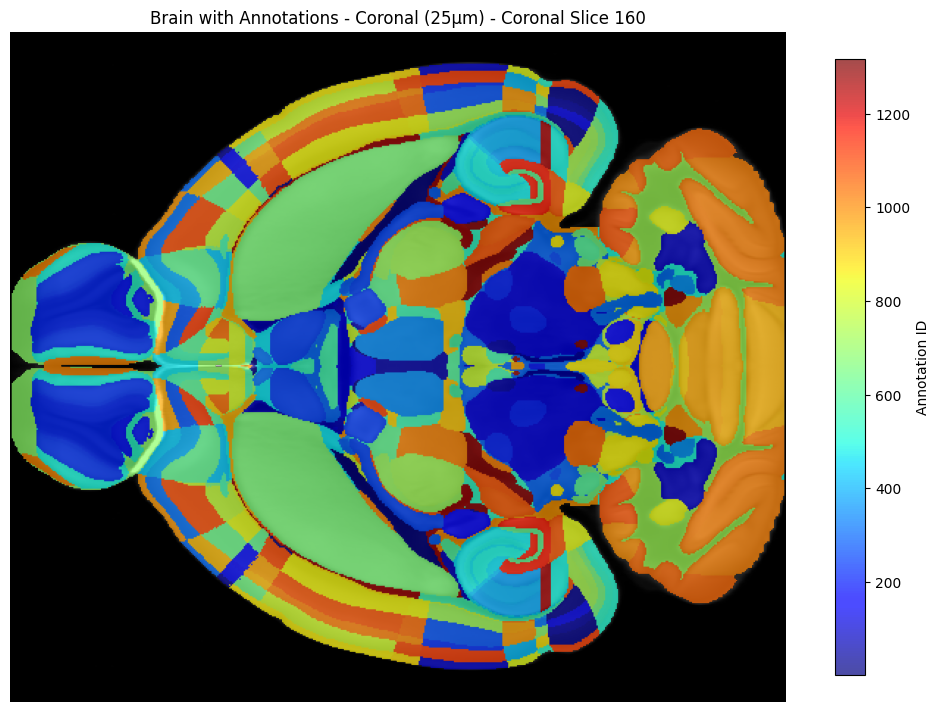

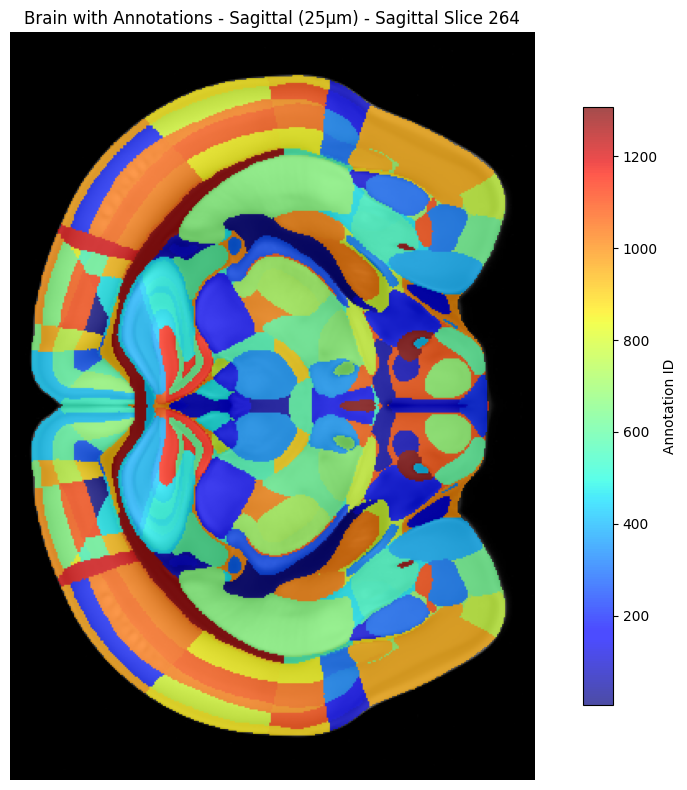

In [9]:
# Create overlay visualization
if template_data is not None and annotation_data is not None:
    # Axial overlay
    fig3, ax3 = visualize_overlay(template_data, annotation_data, mid_axial, 
                                 axis=2, alpha=0.7, annotation_cmap='jet',
                                 title=f"Brain with Annotations ({resolution})")
    plt.show()
    
    # Coronal overlay
    fig4, ax4 = visualize_overlay(template_data, annotation_data, mid_coronal, 
                                 axis=1, alpha=0.7, annotation_cmap='jet',
                                 title=f"Brain with Annotations - Coronal ({resolution})")
    plt.show()
    
    # Sagittal overlay
    fig5, ax5 = visualize_overlay(template_data, annotation_data, mid_sagittal, 
                                 axis=0, alpha=0.7, annotation_cmap='jet',
                                 title=f"Brain with Annotations - Sagittal ({resolution})")
    plt.show()

In [10]:
# Export example images as PNG files
if template_data is not None and annotation_data is not None:
    output_dir = data_dir / Path('exported_images')
    output_dir.mkdir(exist_ok=True)
    
    # Create and save different views
    views = [
        (mid_axial, 2, 'axial'),
        (mid_coronal, 1, 'coronal'),
        (mid_sagittal, 0, 'sagittal')
    ]
    
    for slice_idx, axis, view_name in views:
        # Create overlay figure
        fig, ax = visualize_overlay(template_data, annotation_data, slice_idx, 
                                   axis=axis, alpha=0.7, annotation_cmap='jet',
                                   title=f"Mouse Brain - {view_name.title()} View ({resolution})")
        
        # Save as PNG
        filename = output_dir / f"mouse_brain_{view_name}_{resolution}_{slice_idx}.png"
        save_figure_as_png(fig, str(filename))  # Convert Path to string
        plt.close(fig)  # Close to save memory
    
    print(f"\nExported images saved in: {output_dir}")


Figure saved as: exported_images/mouse_brain_axial_25μm_228.png
Figure saved as: exported_images/mouse_brain_coronal_25μm_160.png
Figure saved as: exported_images/mouse_brain_sagittal_25μm_264.png

Exported images saved in: exported_images


Exploring 3 Axial slices starting from slice 227


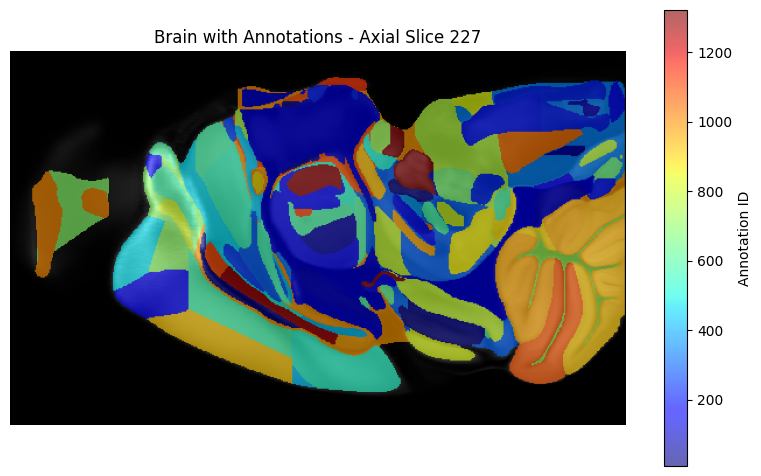

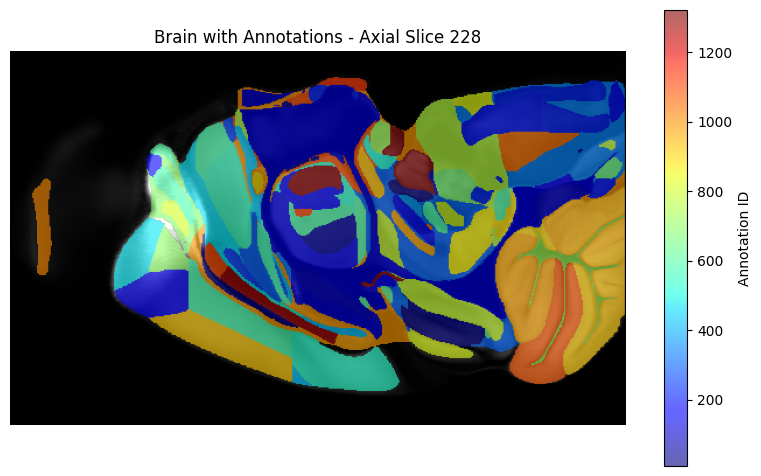

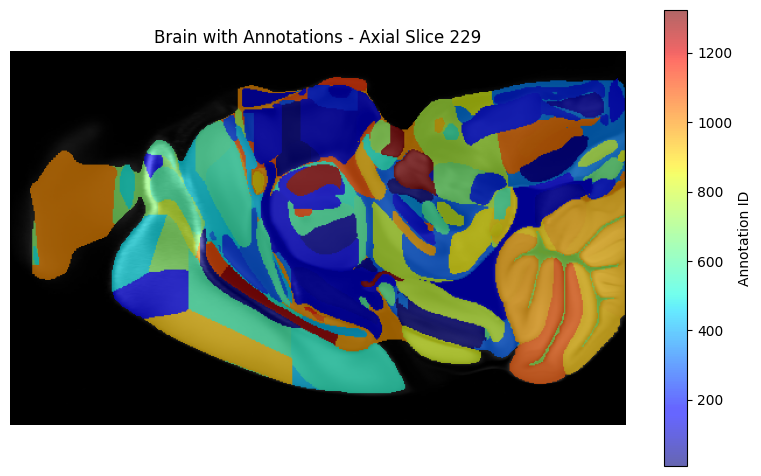

In [11]:
# Interactive slice exploration function
def explore_slices(template_data, annotation_data, axis=2, start_slice=None, num_slices=5):
    """
    Display multiple slices for exploration.
    
    Parameters:
    template_data, annotation_data: 3D numpy arrays
    axis: which axis to slice along (0, 1, or 2)
    start_slice: starting slice index (if None, starts from middle)
    num_slices: number of slices to display
    """
    if template_data is None or annotation_data is None:
        print("No data available for exploration.")
        return
    
    max_slice = template_data.shape[axis]
    
    if start_slice is None:
        start_slice = max_slice // 2 - num_slices // 2
    
    start_slice = max(0, min(start_slice, max_slice - num_slices))
    
    axis_names = ['Sagittal', 'Coronal', 'Axial']
    
    print(f"Exploring {num_slices} {axis_names[axis]} slices starting from slice {start_slice}")
    
    for i in range(num_slices):
        slice_idx = start_slice + i
        if slice_idx >= max_slice:
            break
            
        fig, ax = visualize_overlay(template_data, annotation_data, slice_idx, 
                                   axis=axis, alpha=0.6, figsize=(8, 6))
        plt.show()

# Example usage - explore 3 axial slices around the middle
if template_data is not None:
    explore_slices(template_data, annotation_data, axis=2, num_slices=3)


In [12]:
# Summary of unique annotation values
if annotation_data is not None:
    unique_values = np.unique(annotation_data)
    print(f"Number of unique annotation regions: {len(unique_values)}")
    print(f"Annotation value range: {unique_values.min()} to {unique_values.max()}")
    print(f"First 20 annotation IDs: {unique_values[:20]}")
    
    # Count non-zero voxels
    annotated_voxels = np.sum(annotation_data > 0)
    total_voxels = annotation_data.size
    print(f"Annotated voxels: {annotated_voxels:,} / {total_voxels:,} ({100*annotated_voxels/total_voxels:.1f}%)")


Number of unique annotation regions: 686
Annotation value range: 0.0 to 1327.0
First 20 annotation IDs: [ 0.  1.  2.  5.  6.  8.  9. 11. 13. 15. 17. 18. 21. 23. 24. 25. 27. 29.
 31. 32.]
Annotated voxels: 32,387,384 / 77,045,760 (42.0%)
